<a href="https://colab.research.google.com/github/mikulicmateo/StockPrediction/blob/main/MultioutputModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, BatchNormalization
from keras.layers.core import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from matplotlib import pyplot
from datetime import datetime
import tensorflow as tf

In [4]:

def calculate_typical_price(row):
    typical_price = (row[1] + row[2] + row[3])/3
    return typical_price

In [5]:
with open("/content/drive/MyDrive/dataset-recent.json") as json_file:
    dataset = json.loads(json_file.read())

In [6]:
num_given_days = 60
num_predicted_days = 30
data_per_day = 8

seq_len_x = num_given_days * data_per_day
seq_stride_x = data_per_day
seq_len_y = num_predicted_days
seq_stride_y = 1

In [7]:
def make_y(data):
  new_data = []
  for i in range(len(data)):
    if i % data_per_day != 0:
      continue
    new_data.append(calculate_typical_price(data[i:i+data_per_day]))
  return new_data

In [8]:
def normalize(val, min_val, max_val):
  return (val - min_val) / (max_val - min_val)

In [9]:
def normalize_vals(arr):
  
  arr[0]= normalize(arr[0], open_minmax[0], open_minmax[1])
  arr[1]= normalize(arr[1], high_minmax[0], high_minmax[1])
  arr[2]= normalize(arr[2], low_minmax[0], low_minmax[1])
  arr[3]= normalize(arr[3], close_minmax[0], close_minmax[1])
  arr[4]= normalize(arr[4], volume_minmax[0], volume_minmax[1])
  arr[5]= normalize(arr[5], rsi_minmax[0], rsi_minmax[1])
  arr[6]= normalize(arr[6], sma_minmax[0], sma_minmax[1])
  arr[7]= normalize(arr[7], ema_minmax[0], ema_minmax[1])

  return arr

In [10]:
def update_minmax(curr_vals, update_val):
  if len(curr_vals) == 0:
    curr_vals = [update_val, update_val]
  if update_val < curr_vals[0]:
    curr_vals[0] = update_val
  elif update_val > curr_vals[1]:
    curr_vals[1] = update_val
  return curr_vals

In [11]:
open_minmax = []
high_minmax = []
low_minmax = []
close_minmax = []
volume_minmax = []
rsi_minmax = []
sma_minmax = []
ema_minmax = []

def update_minmax_vals(open, high, low, close, volume, rsi, sma, ema):
  global open_minmax 
  global high_minmax 
  global low_minmax 
  global close_minmax
  global volume_minmax
  global rsi_minmax 
  global sma_minmax 
  global ema_minmax
  
  open_minmax = update_minmax(open_minmax, open)
  high_minmax = update_minmax(high_minmax, high)
  low_minmax = update_minmax(low_minmax, low)
  close_minmax = update_minmax(close_minmax, close)
  volume_minmax = update_minmax(volume_minmax, volume)
  rsi_minmax = update_minmax(rsi_minmax, rsi)
  sma_minmax = update_minmax(sma_minmax, sma)
  ema_minmax = update_minmax(ema_minmax, ema)


In [12]:
def initialize_normalization_vals(dataset):
  for j in dataset.keys():
    for i in dataset[j]:
      date_string = i.get('date')
      if date_string < "2018-01-01":
          update_minmax_vals(float(i.get('open')), float(i.get('high')), float(i.get('low')), float(i.get('close')), \
              float(i.get('volume')), float(i.get('rsi')), float(i.get('sma')), float(i.get('ema')))

In [13]:
def normalize_x_dataset(x_dataset):
  new_x_dataset = []
  for i in range(len(x_dataset)):
    if i % data_per_day != 0:
      continue
    new_x_dataset = new_x_dataset + normalize_vals(x_dataset[i:i+data_per_day])
  return new_x_dataset

In [14]:
ds_train_x = None
ds_train_y = None

ds_valid_x = None
ds_valid_y = None

ds_test_x = None
ds_test_y = None

def load_from_d(dataset, init_norm_vals):
  global ds_train_x
  global ds_train_y
  global ds_valid_x
  global ds_valid_y
  global ds_test_x   
  global ds_test_y

  if init_norm_vals:
    initialize_normalization_vals(dataset)

  for j in dataset.keys():
    data_train = []
    data_valid = []
    data_test = []
    for i in dataset[j]:
      date_string = i.get('date')
      if date_string < "2018-01-01":
          data_train = [float(i.get('open')), float(i.get('high')), float(i.get('low')), float(i.get('close')), \
              float(i.get('volume')), float(i.get('rsi')), float(i.get('sma')), float(i.get('ema'))] + data_train
          
      elif date_string < "2020-01-01":
          data_valid = [float(i.get('open')), float(i.get('high')), float(i.get('low')), float(i.get('close')), \
              float(i.get('volume')), float(i.get('rsi')), float(i.get('sma')), float(i.get('ema'))] + data_valid
      else:
          data_test = [float(i.get('open')), float(i.get('high')), float(i.get('low')), float(i.get('close')), \
              float(i.get('volume')), float(i.get('rsi')), float(i.get('sma')), float(i.get('ema'))] + data_test
          
    if len(data_train) >= seq_len_x:
      
      target_train = make_y(data_train)

      data_train = normalize_x_dataset(data_train)

      x_train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          data_train,
          None,
          sequence_length=seq_len_x,
          sequence_stride=seq_stride_x,
          sampling_rate=1,
          batch_size=None,
          end_index=len(data_train)-(data_per_day * num_predicted_days)
      )

      y_train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          target_train,
          None,
          sequence_length=seq_len_y,
          sequence_stride=seq_stride_y,
          sampling_rate=1,
          batch_size=None,
          start_index=num_given_days,
      )

    if len(data_valid) >= seq_len_x:

      target_valid = make_y(data_valid)

      data_valid = normalize_x_dataset(data_valid)

      x_valid_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          data_valid,
          None,
          sequence_length=seq_len_x,
          sequence_stride=seq_stride_x,
          sampling_rate=1,
          batch_size=None,
          end_index=len(data_valid)-(data_per_day * num_predicted_days)
      )

      y_valid_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          target_valid,
          None,
          sequence_length=seq_len_y,
          sequence_stride=seq_stride_y,
          sampling_rate=1,
          batch_size=None,
          start_index=num_given_days,
      )

    if len(data_test) >= seq_len_x:
      print(len(data_test))
      target_test = make_y(data_test)

      data_test = normalize_x_dataset(data_test)

      x_test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          data_test,
          None,
          sequence_length=seq_len_x,
          sequence_stride=seq_stride_x,
          sampling_rate=1,
          batch_size=None,
          end_index=len(data_test)-(data_per_day * num_predicted_days)
      )

      y_test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          target_test,
          None,
          sequence_length=seq_len_y,
          sequence_stride=seq_stride_y,
          sampling_rate=1,
          batch_size=None,
          start_index=num_given_days,
      )

    if not ds_train_x:
      ds_train_x = x_train_dataset
      ds_train_y = y_train_dataset
      ds_valid_x = x_valid_dataset
      ds_valid_y = y_valid_dataset
      ds_test_x = x_test_dataset
      ds_test_y = y_test_dataset
    else:
      ds_train_x = ds_train_x.concatenate(x_train_dataset)
      ds_train_y = ds_train_y.concatenate(y_train_dataset)
      ds_valid_x = ds_valid_x.concatenate(x_valid_dataset)
      ds_valid_y = ds_valid_y.concatenate(y_valid_dataset)
      ds_test_x = ds_test_x.concatenate(x_test_dataset)
      ds_test_y = ds_test_y.concatenate(y_test_dataset)

In [15]:
load_from_d(dataset, True)

4928
4928
4928
4928
4928
4928
4928
4928
4928
2128
4928
4928
4928
4928
4928
4928
4928
4928
4928
2808
4872
3288
4928
4928
3224
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
3576
1296
4928
4928
4760
4552
4928
4928
4928
4928
4928
4928
4928
2336
4928
3800
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
1752
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
4928
976
4928
4928
4928
4928
4928
2880
4928
4928
4928
3408
4928
4928
4928
4928
3528
4928
3640
2648
4928
4928
4928
4096
3472
4928
4928
4928
4928
4928
4928
2912
4928
4928
4928
4200
4928


In [16]:
def create_model():
  l_model = Sequential()
  l_model.add(Input(480))
#  l_model.add(Dense(960, activation="relu"))
#  l_model.add(Dense(480, activation="softplus"))
  l_model.add(Dense(240, activation="relu"))
  l_model.add(Dense(120, activation="softplus"))
  l_model.add(Dropout(0.5))
  l_model.add(Dense(60, activation="linear"))
  l_model.add(Dense(30, activation="softplus"))
  l_model.compile(Adam(learning_rate=0.001), loss="msle", metrics=["mse", "mae", "msle"])
  return l_model

In [17]:
ds_train = tf.data.Dataset.zip((ds_train_x , ds_train_y)).batch(32)

In [18]:
ds_valid = tf.data.Dataset.zip((ds_valid_x, ds_valid_y)).batch(32)

In [19]:
for x,y in ds_valid:
  print(x.shape)
  print(y.shape)
  break
 

(32, 480)
(32, 30)


In [20]:
for x,y in ds_train:
  print(x.shape)
  print(y.shape)
  break

(32, 480)
(32, 30)


In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000001)

In [22]:
model = create_model()
model.summary()
history = model.fit(ds_train, validation_data=ds_valid, epochs=70, verbose=1, shuffle=True, callbacks=[learning_rate_reduction])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 240)               115440    
                                                                 
 dense_1 (Dense)             (None, 120)               28920     
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_2 (Dense)             (None, 60)                7260      
                                                                 
 dense_3 (Dense)             (None, 30)                1830      
                                                                 
Total params: 153,450
Trainable params: 153,450
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
14499/14499 [==========================

In [23]:
results = model.evaluate(ds_valid)
print(results)

1626/1626 [==============================] - 37s 11ms/step - loss: 0.0147 - mse: 705.5598 - mae: 5.9082 - msle: 0.0147
[0.01472639013081789, 705.559814453125, 5.908203601837158, 0.01472639013081789]


In [24]:
ds_test_xx = ds_test_x.batch(32)
for x in ds_test_xx:
  print(x.shape)
  break

(32, 480)


In [25]:
predictions = model.predict(ds_test_xx)
print(predictions)

[[104.19898  104.19345  104.192986 ... 104.18182  104.16594  104.15428 ]
 [106.024895 106.01908  106.01889  ... 106.01213  105.99573  105.98367 ]
 [106.59643  106.59052  106.59041  ... 106.584915 106.56831  106.55618 ]
 ...
 [ 54.817276  54.81692   54.8192   ...  54.883766  54.879807  54.87645 ]
 [ 53.73236   53.73214   53.734394 ...  53.799213  53.79554   53.79238 ]
 [ 53.626305  53.62607   53.628384 ...  53.694016  53.690357  53.687214]]


In [26]:
ds_test_yy = ds_test_y.batch(32)

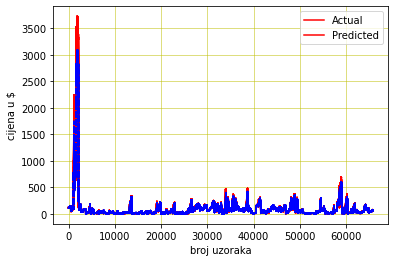

<Figure size 432x288 with 0 Axes>

In [27]:
pyplot.plot(list(ds_test_y), linestyle='solid', color='r')
pyplot.plot(predictions, linestyle='dashed', color='b')
pyplot.legend(['Actual','Predicted'], loc='best')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.ylabel("cijena u $")
pyplot.xlabel("broj uzoraka")
pyplot.show()
pyplot.savefig('whole-test.svg')

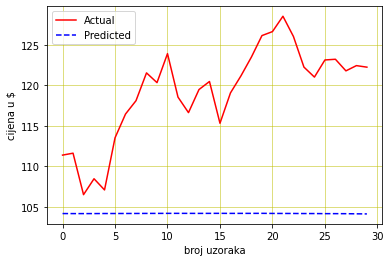

<Figure size 432x288 with 0 Axes>

In [28]:
pyplot.plot(list(ds_test_y)[0], linestyle='solid', color='r')
pyplot.plot(predictions[0], linestyle='dashed', color='b')
pyplot.legend(['Actual','Predicted'], loc='best')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.ylabel("cijena u $")
pyplot.xlabel("broj uzoraka")
pyplot.show()
pyplot.savefig('snippet-test.png')

In [29]:
real = []
predicted = []
for real_vals, predicted_vals in zip(list(ds_test_y),list(predictions)):
  real = real + list(real_vals)
  predicted = predicted + list(predicted_vals)

sum = 0
for i in range(len(real)-1):
  sum = sum + abs(real[i] - predicted[i])

print("MAE: ", sum/len(real))

MAE:  tf.Tensor(12.581433, shape=(), dtype=float32)


In [30]:
from scipy.stats import pearsonr, spearmanr

pcorr, _ = pearsonr(real, predicted) #>0.5 and close to 1 high level of correlation
scorr, _ = spearmanr(real, predicted)
print("Pearson's correlation: ", pcorr)
print("Spearman's correlation: ", scorr)

Pearson's correlation:  0.9905882394911121
Spearman's correlation:  0.9927322066600245


In [31]:
sum_mse1 = 0
for i in range(len(real)-1):
  sum_mse1 = sum_mse1 + ((real[i] - predicted[i]) ** 2)

print("MSE: ", sum_mse1/len(real))

MSE:  tf.Tensor(3650.0935, shape=(), dtype=float32)


#### rmse

In [32]:
import math

sum_rmse1 = 0
for i in range(len(real)-1):
  sum_rmse1 = sum_rmse1 + ((predicted[i] - real[i]) ** 2)

rmse1 = math.sqrt(sum_rmse1/len(real)) 

In [33]:
print("RMSE: ", rmse1)

RMSE:  60.4160037230151


#### msle

In [34]:
sum_msle1 = 0

for i in range(len(real)-1):
  sum_msle1 =  sum_msle1 + ((math.log(real[i]+1)-math.log(predicted[i]+1)) ** 2)

print("MSLE: ", sum_msle1/len(real))

MSLE:  0.02182897995182379


In [ ]:
model.save('model_with_dropout.h5')

#############################################################################

# EXPERIMENT

In [35]:
with open("/content/drive/MyDrive/experiment-sets/dataset-experiment-oxy.json") as json_file: #load data
    experiment_dataset = json.loads(json_file.read())

In [36]:
ds_train_x = None
ds_train_y = None
ds_valid_x = None
ds_valid_y = None
ds_test_x = None
ds_test_y = None
load_from_d(experiment_dataset, False)

5016


In [37]:
predictions_experiment = model.predict(ds_test_x.batch(32))

In [38]:
experiment_real_vals = []
experiment_predicted_vals = []

for real_vals in list(ds_test_y):
  experiment_real_vals = experiment_real_vals + list(real_vals)

for predicted_vals in list(predictions_experiment):
  experiment_predicted_vals = experiment_predicted_vals + list(predicted_vals)

### Correlations

In [39]:
experiment_pcorr, _ = pearsonr(experiment_real_vals, experiment_predicted_vals) #>0.5 and close to 1 high level of correlation
experiment_scorr, _ = spearmanr(experiment_real_vals, experiment_predicted_vals)
print("Pearson's correlation: ", experiment_pcorr)
print("Spearman's correlation: ", experiment_scorr)

Pearson's correlation:  0.9535474663061938
Spearman's correlation:  0.9211467022596208


### MAE

In [40]:
sum_mae = 0
for i in range(len(experiment_real_vals)-1):
  sum = sum + abs(experiment_real_vals[i] - experiment_predicted_vals[i])

print("MAE = ", sum/len(experiment_real_vals))

MAE =  tf.Tensor(1542.92, shape=(), dtype=float32)


 ### MSE

In [41]:
sum_mse = 0
for i in range(len(experiment_real_vals)-1):
  sum_mse = sum_mse + ((experiment_real_vals[i] - experiment_predicted_vals[i]) ** 2)

print("MSE: ", sum_mse/len(experiment_real_vals))

MSE:  tf.Tensor(22.589289, shape=(), dtype=float32)


### RMSE

In [42]:
sum_rmse = 0
for i in range(len(experiment_real_vals)-1):
  sum_rmse = sum_rmse + ((experiment_predicted_vals[i] - experiment_real_vals[i]) ** 2)

rmse = math.sqrt(sum_rmse/len(experiment_real_vals)) 

In [43]:
print("RMSE: ", rmse)

RMSE:  4.752819027855768


### MSLE

In [44]:
sum_msle = 0

for i in range(len(experiment_real_vals)-1):
  sum_msle =  sum_msle + ((math.log(experiment_real_vals[i]+1)-math.log(experiment_predicted_vals[i]+1)) ** 2)

print("MSLE: ", sum_msle/len(experiment_real_vals))

MSLE:  0.02817787959233864


In [45]:
print(len(list(ds_test_y)))
print(len(predictions_experiment))

538
538


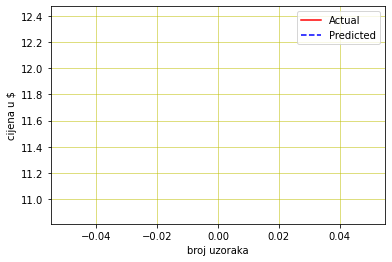

<Figure size 432x288 with 0 Axes>

In [46]:
pyplot.plot(experiment_real_vals[0], linestyle='solid', color='r')
pyplot.plot(experiment_predicted_vals[0], linestyle='dashed', color='b')
pyplot.legend(['Actual','Predicted'], loc='best')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.ylabel("cijena u $")
pyplot.xlabel("broj uzoraka")
pyplot.show()
pyplot.savefig('snippet-experiment.png')

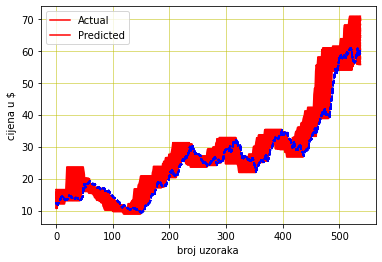

<Figure size 432x288 with 0 Axes>

In [47]:
pyplot.plot(list(ds_test_y), linestyle='solid', color='r')
pyplot.plot(predictions_experiment, linestyle='dashed', color='b')
pyplot.legend(['Actual','Predicted'], loc='best')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.ylabel("cijena u $")
pyplot.xlabel("broj uzoraka")
pyplot.show()
pyplot.savefig('snippet-experiment.png')

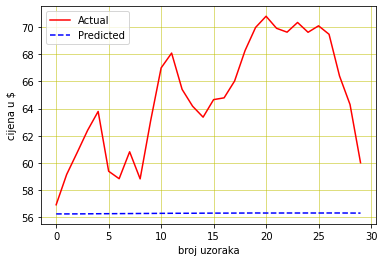

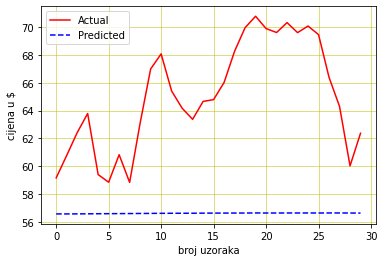

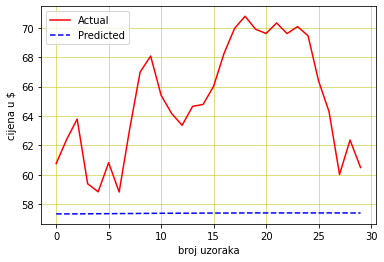

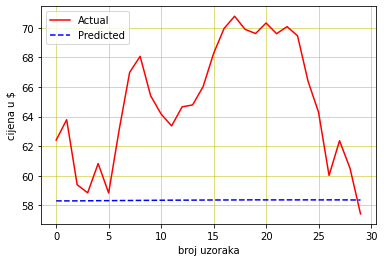

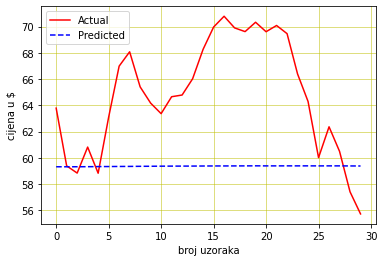

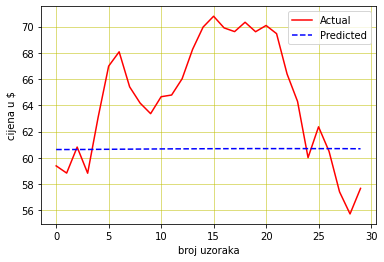

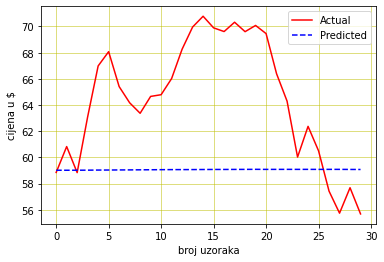

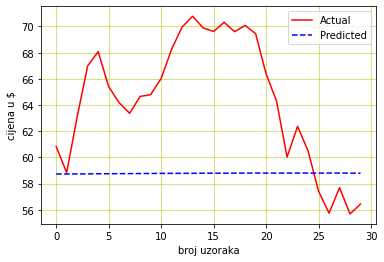

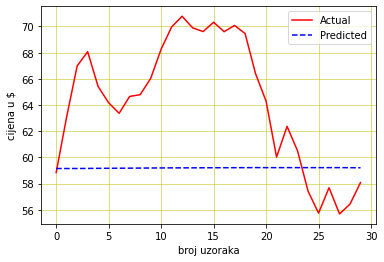

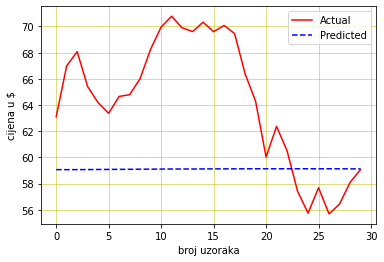

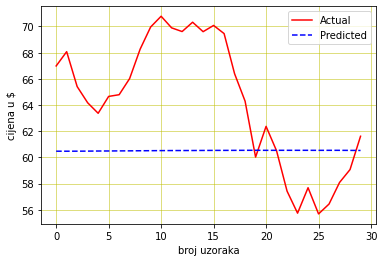

<Figure size 432x288 with 0 Axes>

In [48]:
for i in range(527,538):
  pyplot.plot(list(ds_test_y)[i], linestyle='solid', color='r')
  pyplot.plot(predictions_experiment[i], linestyle='dashed', color='b')
  pyplot.legend(['Actual','Predicted'], loc='best')
  pyplot.grid(color = 'y', linewidth='0.5')
  pyplot.ylabel("cijena u $")
  pyplot.xlabel("broj uzoraka")
  pyplot.show()
  pyplot.savefig('snippet-experiment.png')

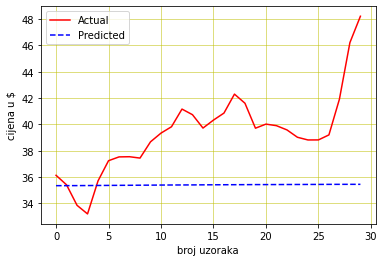

<Figure size 432x288 with 0 Axes>

In [49]:
pyplot.plot(list(ds_test_y)[456], linestyle='solid', color='r')
pyplot.plot(predictions_experiment[456], linestyle='dashed', color='b')
pyplot.legend(['Actual','Predicted'], loc='best')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.ylabel("cijena u $")
pyplot.xlabel("broj uzoraka")
pyplot.show()
pyplot.savefig('snippet-experiment.png')

#############################################################################

# Predictions on test data

In [ ]:
import random

graph_to_display = random.randint(0,len(predictions)-1)

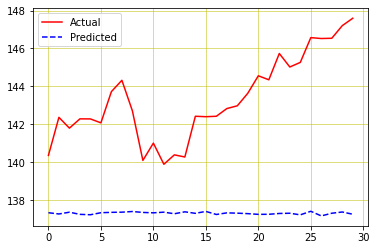

In [ ]:
pyplot.plot(list(ds_test_y)[graph_to_display], linestyle='solid', color='r')
pyplot.plot(predictions[graph_to_display], linestyle='dashed', color='b')
pyplot.legend(['Actual','Predicted'], loc='best')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.show()

In [ ]:
print(len(list(ds_test_y)))
print(len(predictions))

52914
52914


## Actual

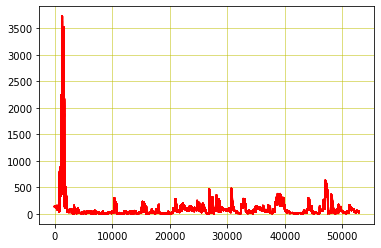

In [ ]:
pyplot.plot(list(ds_test_y)[graph_to_display], linestyle='solid', color='r')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.show()

## Predicted

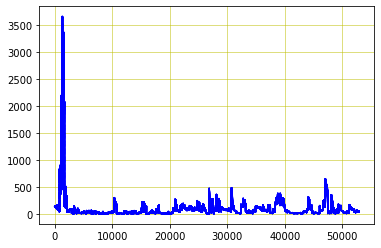

In [ ]:
pyplot.plot(predictions[graph_to_display], linestyle='dashed', color='b')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.show()

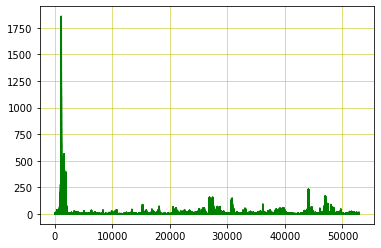

In [ ]:
difference = []
zip_object = zip(predictions[graph_to_display], list(ds_test_y)[graph_to_display])
for list1_i, list2_i in zip_object:
    difference.append(abs(list1_i-list2_i))

pyplot.plot(difference, linestyle='dashed', color='g')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.show()

In [ ]:
print(difference)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Predictions on train data

In [ ]:
predictions_train = model.predict(ds_train_x.batch(32))

In [ ]:
graph_to_display = random.randint(0,len(predictions_train)-1)

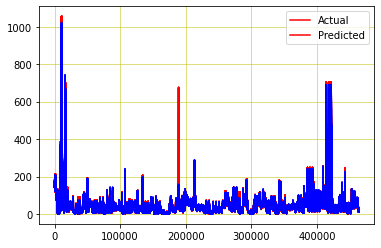

In [ ]:
pyplot.plot(list(ds_train_y)[graph_to_display], linestyle='solid', color='r')
pyplot.plot(predictions_train[graph_to_display], linestyle='dashed', color='b')
pyplot.legend(['Actual','Predicted'], loc='best')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.show()

## Actual

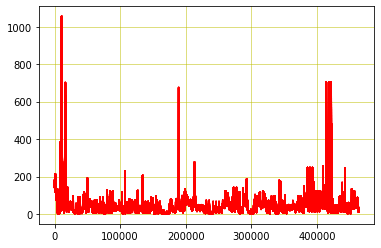

In [ ]:
pyplot.plot(list(ds_train_y)[graph_to_display], linestyle='solid', color='r')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.show()

## Predicted

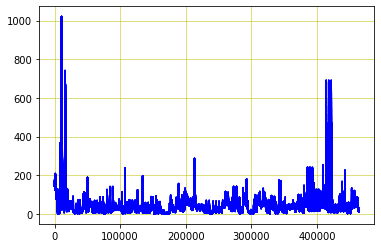

In [ ]:
pyplot.plot(predictions_train[graph_to_display], linestyle='dashed', color='b')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.show()

# AMD prediction

In [ ]:
with open("/content/drive/MyDrive/dataset-amd.json") as json_file:
    amd_dataset = json.loads(json_file.read())

In [ ]:
ds_train_x = None
ds_train_y = None
ds_valid_x = None
ds_valid_y = None
ds_test_x = None
ds_test_y = None
load_from_d(amd_dataset, False)

In [ ]:
predictions_amd = model.predict(ds_test_x.batch(32))

In [ ]:
graph_to_display = random.randint(0,len(predictions_amd)-1)

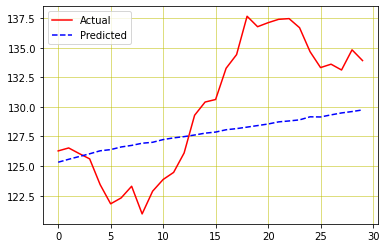

In [ ]:
pyplot.plot(list(ds_test_y)[graph_to_display], linestyle='solid', color='r')
pyplot.plot(predictions_amd[graph_to_display], linestyle='dashed', color='b')
pyplot.legend(['Actual','Predicted'], loc='best')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.show()

In [ ]:
print(len(list(ds_test_y)))
print(len(predictions_amd))

445
445


# One 60->30 days prediction

In [ ]:
with open("/content/drive/MyDrive/dataset-simple.json") as json_file:
    simple_dataset = json.loads(json_file.read())

In [ ]:
ds_train_x = None
ds_train_y = None
ds_valid_x = None
ds_valid_y = None
ds_test_x = None
ds_test_y = None
load_from_d(simple_dataset, False)

720


In [ ]:
predictions_simple = model.predict(ds_test_x.batch(32))

In [ ]:
graph_to_display = random.randint(0,len(predictions_simple)-1)

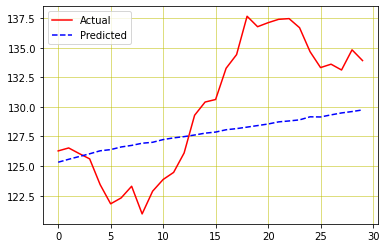

In [ ]:
pyplot.plot(list(ds_test_y)[graph_to_display], linestyle='solid', color='r')
pyplot.plot(predictions_simple[graph_to_display], linestyle='dashed', color='b')
pyplot.legend(['Actual','Predicted'], loc='best')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.show()

In [ ]:
print(len(list(ds_test_y)))
print(len(predictions_simple))

1
1


In [ ]:
print(list(ds_test_y))

[<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([126.28167 , 126.53167 , 126.0601  , 125.61003 , 123.433334,
       121.81333 , 122.3113  , 123.2975  , 120.96    , 122.88    ,
       123.86667 , 124.46667 , 126.10667 , 129.29333 , 130.41    ,
       130.62334 , 133.25996 , 134.41667 , 137.65666 , 136.77333 ,
       137.11076 , 137.395   , 137.457   , 136.68834 , 134.66333 ,
       133.32    , 133.60667 , 133.11667 , 134.82    , 133.91203 ],
      dtype=float32)>]


In [ ]:
print(predictions_simple)

[[125.32684 125.57419 125.80651 126.03855 126.2911  126.39133 126.61446
  126.74678 126.92992 127.01042 127.2383  127.38268 127.48884 127.62556
  127.78111 127.87276 128.0691  128.16396 128.2922  128.4213  128.55457
  128.73361 128.81221 128.90404 129.16159 129.1491  129.32553 129.48915
  129.6058  129.74467]]


# Testing timeseries_dataset functions

In [ ]:
test_functions_dataset = []
ds_train_x_testing = None
ds_train_y_testing = None

def test_dataset_making(testing_dataset):

   global ds_train_x_testing
   global ds_train_y_testing
   print(len(testing_dataset))
   if len(testing_dataset) >= seq_len_x:
     
     target_train = make_y(testing_dataset)

     x_train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
         testing_dataset,
         None,
         sequence_length=seq_len_x,
         sequence_stride=seq_stride_x,
         sampling_rate=1,
         batch_size=None,
         end_index=len(testing_dataset)-(data_per_day * num_predicted_days)
     )

     y_train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
         target_train,
         None,
         sequence_length=seq_len_y,
         sequence_stride=seq_stride_y,
         sampling_rate=1,
         batch_size=None,
         start_index=num_given_days,
     )

   if not ds_train_x_testing:
     ds_train_x_testing = x_train_dataset
     ds_train_y_testing = y_train_dataset
   else:
     ds_train_x_testing = ds_train_x_testing.concatenate(x_train_dataset)
     ds_train_y_testing = ds_train_y_testing.concatenate(y_train_dataset)

In [ ]:
for i in range(900):
  test_functions_dataset = test_functions_dataset + [1, 2, 1, 1, 1000, 50, 50, 50]

test_dataset_making(test_functions_dataset)

7200


In [ ]:
ds_testing = tf.data.Dataset.zip((ds_train_x_testing,ds_train_y_testing)).batch(1)

In [ ]:
for x,y in ds_testing:
  print(x)
  print(y)
  print("_____________________________________________")

Streaming output truncated to the last 5000 lines.
  1000   50   50   50    1    2    1    1 1000   50   50   50    1    2
     1    1 1000   50   50   50    1    2    1    1 1000   50   50   50
     1    2    1    1 1000   50   50   50    1    2    1    1 1000   50
    50   50    1    2    1    1 1000   50   50   50    1    2    1    1
  1000   50   50   50]], shape=(1, 480), dtype=int32)
tf.Tensor(
[[1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334
  1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334
  1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334
  1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334
  1.3333334 1.3333334]], shape=(1, 30), dtype=float32)
_____________________________________________
tf.Tensor(
[[   1    2    1    1 1000   50   50   50    1    2    1    1 1000   50
    50   50    1    2    1    1 1000   50   50   50    1    2    1    1
  1000   50   50   50    1    2    1    1 1000   50 